In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy
from scipy.stats import norm
import pylab
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/jedapa/scripts/MIOTI_DS_AD_project.csv')
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.strftime('%Y/%m/%d %H:%M:%S')
df['time'] = pd.DatetimeIndex(df['time'])

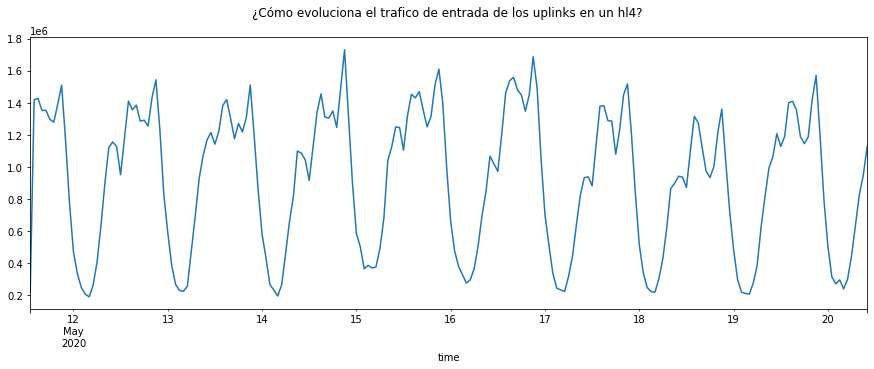

In [3]:
# Eliminamos de la columna KPI el nombre del host
df_clean = df.replace(to_replace ='hl413vdpn1-301.', value = '', regex = True) 

# Pivotamos la tabla para tener los Kpis como columnas e indexamos por tiempo y device
df_pivot = df_clean.pivot_table(values='value',index=['time','device'],columns='kpi')
df_pivot_final = df_pivot.reset_index(level = 1, col_level = 1)

# Hacemos resampleo a horas, puesto que queremos predecir las proximas 24 y tenemos muestras cada 10 min
df_pivot_final_hourly = df_pivot_final.resample('h').sum()


df_pivot_final_hourly['interfaces_ae1.input.bps'].plot(figsize=(15,5),
                  title='¿Cómo evoluciona el trafico de entrada de los uplinks en un hl4? \n')

df_TimeSeriesData = pd.DataFrame(df_pivot_final_hourly['interfaces_ae1.input.bps'])


In [4]:
df_TimeSeriesData

,interfaces_ae1.input.bps
time,
2020-05-11 13:00:00,216124
2020-05-11 14:00:00,1419466
2020-05-11 15:00:00,1427112
2020-05-11 16:00:00,1351985
2020-05-11 17:00:00,1353158
...,...
2020-05-20 06:00:00,443417
2020-05-20 07:00:00,637413
2020-05-20 08:00:00,827340


In [5]:
## Periodos en los que vamos a hacer la predicción
periodos = pd.date_range('2020-05-20 11:00:00', periods = 24, freq = 'H')
periodos

DatetimeIndex(['2020-05-20 11:00:00', '2020-05-20 12:00:00',
               '2020-05-20 13:00:00', '2020-05-20 14:00:00',
               '2020-05-20 15:00:00', '2020-05-20 16:00:00',
               '2020-05-20 17:00:00', '2020-05-20 18:00:00',
               '2020-05-20 19:00:00', '2020-05-20 20:00:00',
               '2020-05-20 21:00:00', '2020-05-20 22:00:00',
               '2020-05-20 23:00:00', '2020-05-21 00:00:00',
               '2020-05-21 01:00:00', '2020-05-21 02:00:00',
               '2020-05-21 03:00:00', '2020-05-21 04:00:00',
               '2020-05-21 05:00:00', '2020-05-21 06:00:00',
               '2020-05-21 07:00:00', '2020-05-21 08:00:00',
               '2020-05-21 09:00:00', '2020-05-21 10:00:00'],
              dtype='datetime64[ns]', freq='H')

In [6]:
## Creamos un dataframe con nuestras fechas a predecir
df_prediccion = pd.DataFrame({'interfaces_ae1.input.bps':[np.nan]},
                             index = periodos)
df_prediccion

,interfaces_ae1.input.bps
2020-05-20 11:00:00,NaN
2020-05-20 12:00:00,NaN
2020-05-20 13:00:00,NaN
2020-05-20 14:00:00,NaN
2020-05-20 15:00:00,NaN
2020-05-20 16:00:00,NaN
2020-05-20 17:00:00,NaN
2020-05-20 18:00:00,NaN
2020-05-20 19:00:00,NaN
2020-05-20 20:00:00,NaN


In [7]:
## Unimos el dataframe del histórico y el de la predicción
df_TimeSeriesData_final = pd.concat([df_TimeSeriesData, df_prediccion], ignore_index = False)
df_TimeSeriesData_final

,interfaces_ae1.input.bps
2020-05-11 13:00:00,216124.0
2020-05-11 14:00:00,1419466.0
2020-05-11 15:00:00,1427112.0
2020-05-11 16:00:00,1351985.0
2020-05-11 17:00:00,1353158.0
...,...
2020-05-21 06:00:00,NaN
2020-05-21 07:00:00,NaN
2020-05-21 08:00:00,NaN
2020-05-21 09:00:00,NaN


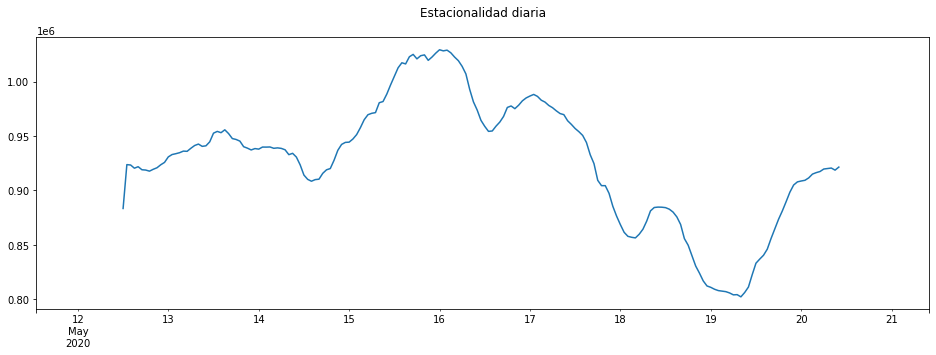

In [8]:
# Quitar la componente estacional diaria

df_TimeSeriesData_final['reg_mm24'] = df_TimeSeriesData_final.rolling(24).mean()
df_TimeSeriesData_final['reg_mm24'].plot(figsize=(16,5),title = 'Estacionalidad diaria\n')

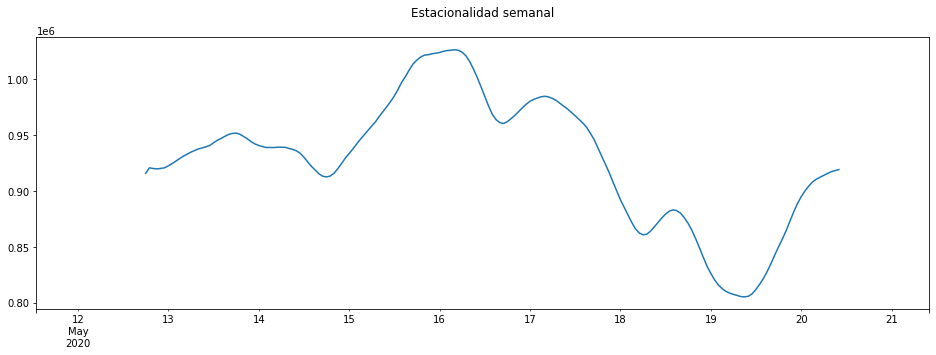

In [9]:
# Quitamos la estacionalidad semanal 
df_TimeSeriesData_final['reg_mm24_7'] = df_TimeSeriesData_final.reg_mm24.rolling(7).mean()
df_TimeSeriesData_final['reg_mm24_7'].plot(figsize=(16,5),title = 'Estacionalidad semanal\n')

In [11]:
# Quitamos la tendencia
df_TimeSeriesData_final['reg_mm24_7_sin_tendencia'] = df_TimeSeriesData_final['reg_mm24_7'] - \
                                                      df_TimeSeriesData_final['reg_mm24_7'].shift(1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12de6fdd0>,
      dtype=object)

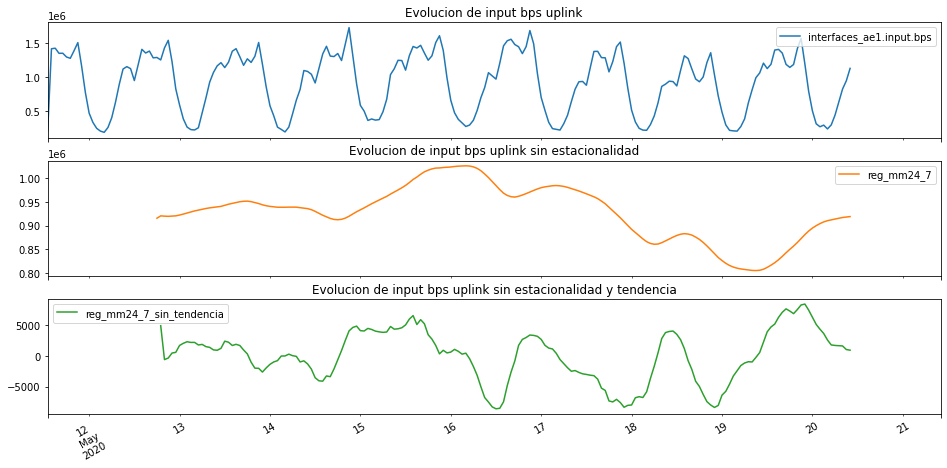

In [12]:
# Representamos la serie con y sin estacionalidad
df_TimeSeriesData_final = df_TimeSeriesData_final[['interfaces_ae1.input.bps','reg_mm24_7','reg_mm24_7_sin_tendencia']]
df_TimeSeriesData_final.iloc[:,:3].plot(subplots = True,figsize=(16,8),title=['Evolucion de input bps uplink',\
                                                                        'Evolucion de input bps uplink sin estacionalidad',\
                                                                        'Evolucion de input bps uplink sin estacionalidad y tendencia'])

In [13]:
# Prevision de un dia
# Creamos la columna de preivion y la inicializamos a NaN
df_TimeSeriesData_final['prevision_1d'] = np.nan
df_TimeSeriesData_final

,interfaces_ae1.input.bps,reg_mm24_7,reg_mm24_7_sin_tendencia,prevision_1d
2020-05-11 13:00:00,216124.0,NaN,NaN,NaN
2020-05-11 14:00:00,1419466.0,NaN,NaN,NaN
2020-05-11 15:00:00,1427112.0,NaN,NaN,NaN
2020-05-11 16:00:00,1351985.0,NaN,NaN,NaN
2020-05-11 17:00:00,1353158.0,NaN,NaN,NaN
...,...,...,...,...
2020-05-21 06:00:00,NaN,NaN,NaN,NaN
2020-05-21 07:00:00,NaN,NaN,NaN,NaN
2020-05-21 08:00:00,NaN,NaN,NaN,NaN
2020-05-21 09:00:00,NaN,NaN,NaN,NaN


In [14]:
# Rellenamos los ultimos 24 datos con el valor medio de la serie sin tendecia ni estacionalidad
df_TimeSeriesData_final['prevision_1d'][-25:] = df_TimeSeriesData_final['reg_mm24_7_sin_tendencia'].mean()
df_TimeSeriesData_final

,interfaces_ae1.input.bps,reg_mm24_7,reg_mm24_7_sin_tendencia,prevision_1d
2020-05-11 13:00:00,216124.0,NaN,NaN,NaN
2020-05-11 14:00:00,1419466.0,NaN,NaN,NaN
2020-05-11 15:00:00,1427112.0,NaN,NaN,NaN
2020-05-11 16:00:00,1351985.0,NaN,NaN,NaN
2020-05-11 17:00:00,1353158.0,NaN,NaN,NaN
...,...,...,...,...
2020-05-21 06:00:00,NaN,NaN,NaN,18.46545
2020-05-21 07:00:00,NaN,NaN,NaN,18.46545
2020-05-21 08:00:00,NaN,NaN,NaN,18.46545
2020-05-21 09:00:00,NaN,NaN,NaN,18.46545


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12e10b1d0>,
      dtype=object)

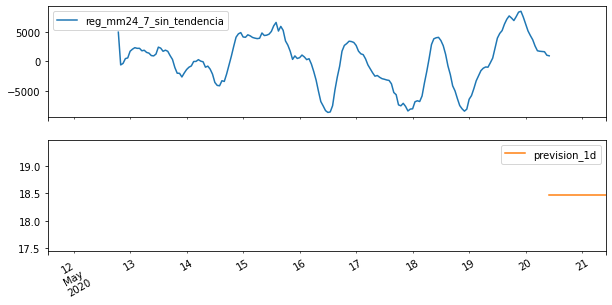

In [15]:
df_TimeSeriesData_final.loc[:,['reg_mm24_7_sin_tendencia','prevision_1d']].plot(figsize = (10,5),
                                                 subplots = True)

In [16]:
# Incorporamos la tendecia a la prevision

df_TimeSeriesData_final['prevision_1d_ct'] = np.nan
df_TimeSeriesData_final['prevision_1d_ct_final'] = np.nan
#
#
df_TimeSeriesData_final['prevision_1d_ct'][-25:] = df_TimeSeriesData_final['reg_mm24_7'][-25]
df_TimeSeriesData_final['prevision_1d_ct_final'][-25:] = df_TimeSeriesData_final['reg_mm24_7'][-25]
#
### Sumamos el acumulado de la previsión a nuestra serie con tendencia
df_TimeSeriesData_final['prevision_1d_ct_final'][-24:] = df_TimeSeriesData_final['prevision_1d'][-24:].cumsum()\
                                     + df_TimeSeriesData_final['prevision_1d_ct'][-24:]
df_TimeSeriesData_final.tail(25)

,interfaces_ae1.input.bps,reg_mm24_7,reg_mm24_7_sin_tendencia,prevision_1d,prevision_1d_ct,prevision_1d_ct_final
2020-05-20 10:00:00,1130691.0,919097.595238,919.345238,18.46545,919097.595238,919097.595238
2020-05-20 11:00:00,NaN,NaN,NaN,18.46545,919097.595238,919116.060688
2020-05-20 12:00:00,NaN,NaN,NaN,18.46545,919097.595238,919134.526139
2020-05-20 13:00:00,NaN,NaN,NaN,18.46545,919097.595238,919152.991589
2020-05-20 14:00:00,NaN,NaN,NaN,18.46545,919097.595238,919171.457039
2020-05-20 15:00:00,NaN,NaN,NaN,18.46545,919097.595238,919189.922490
2020-05-20 16:00:00,NaN,NaN,NaN,18.46545,919097.595238,919208.387940
2020-05-20 17:00:00,NaN,NaN,NaN,18.46545,919097.595238,919226.853390
2020-05-20 18:00:00,NaN,NaN,NaN,18.46545,919097.595238,919245.318841
2020-05-20 19:00:00,NaN,NaN,NaN,18.46545,919097.595238,919263.784291


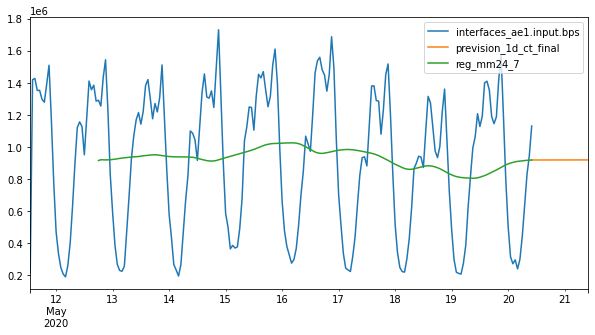

In [17]:
## Representamos nuestra previsión
df_TimeSeriesData_final.loc[:,['interfaces_ae1.input.bps','prevision_1d_ct_final','reg_mm24_7']].plot(figsize=(10,5))

In [21]:
## Incorporamos la estacionalidad a nuestra prevision
## Calculamos los coeficientes de estacionalidad
df_TimeSeriesData_final['coef_estacionalidad']=df_TimeSeriesData_final['interfaces_ae1.input.bps']/df_TimeSeriesData_final['reg_mm24_7']

In [22]:
## Aplicamos los coeficientes de estacionalidad sobre nuestra previsión con tendencia
## Como queremos la previsión para 24 horas, desplazamos esos coeficientes y los multiplicamos por 
## el valor de la previsión con tendencia
df_TimeSeriesData_final['prevision_1d_ct_cs'] = df_TimeSeriesData_final['prevision_1d_ct_final']  \
                                     * df_TimeSeriesData_final['coef_estacionalidad'].shift(24)

In [23]:
df_TimeSeriesData_final

,interfaces_ae1.input.bps,reg_mm24_7,reg_mm24_7_sin_tendencia,prevision_1d,prevision_1d_ct,prevision_1d_ct_final,coef_estacionalidad,prevision_1d_ct_cs
2020-05-11 13:00:00,216124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 14:00:00,1419466.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 15:00:00,1427112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 16:00:00,1351985.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11 17:00:00,1353158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-05-21 06:00:00,NaN,NaN,NaN,18.46545,919097.595238,919466.904244,NaN,4.461142e+05
2020-05-21 07:00:00,NaN,NaN,NaN,18.46545,919097.595238,919485.369695,NaN,6.401529e+05
2020-05-21 08:00:00,NaN,NaN,NaN,18.46545,919097.595238,919503.835145,NaN,8.294564e+05
2020-05-21 09:00:00,NaN,NaN,NaN,18.46545,919097.595238,919522.300595,NaN,9.497653e+05


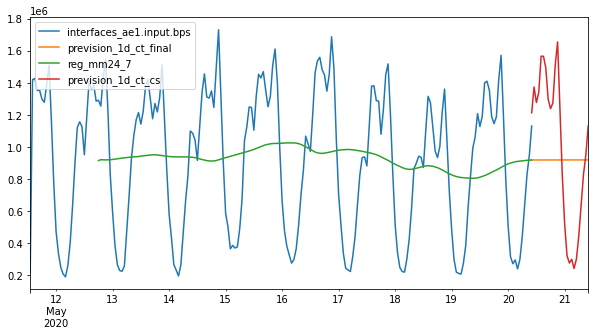

In [24]:
df_TimeSeriesData_final.loc[:,['interfaces_ae1.input.bps','prevision_1d_ct_final','reg_mm24_7','prevision_1d_ct_cs']].plot(figsize=(10,5))